In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pymc.sampling_jax
import pickle

In [3]:
df = pd.read_csv("/home/manalitta/d/PPRV_lineage_IV/data/baseline_data_bernoulli.csv")
df.head()

,experiment,duration,seeder,Cap2,time,infected
0,1,1,436,100,60,0
1,1,1,436,116,60,0
2,1,1,436,255,60,0
3,1,1,436,449,60,0
4,1,1,436,3008,60,0


In [4]:
with pm.Model() as baseline_Bernoulli:
    # Priors
    p = pm.Uniform("p", lower=0.0001, upper=0.01)

    # Calculate probabilities for each data point
    t = pm.ConstantData("t", df['time'])
    probs = pm.Deterministic("probs", 1 - (1 - p) ** t)
    
    # Likelihood
    y_true = pm.Bernoulli('y_obs', p=probs, observed=df['infected'])

/home/manalitta/miniforge3/envs/pymc_env/lib/python3.10/site-packages/pymc/data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [5]:
%%time
with baseline_Bernoulli:
    trace_baseline_Bern = pm.sampling.jax.sample_blackjax_nuts(draws=10000, tune=1000, chains=10, target_accept=0.95)

/home/manalitta/miniforge3/envs/pymc_env/lib/python3.10/site-packages/pymc/sampling/jax.py:368: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


CPU times: user 5.96 s, sys: 90.6 ms, total: 6.05 s
Wall time: 4.49 s


In [6]:
with open('trace_baseline_bernoulli.pkl', 'wb') as f:
    pickle.dump(trace_baseline_Bern, f)

In [8]:
az.summary(trace_baseline_Bern, round_to=4, hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.0002,0.0001,0.0001,0.0003,0.0000,0.0000,22336.6469,18417.0105,1.0005
probs[0],0.0138,0.0033,0.0076,0.0204,0.0000,0.0000,22336.6469,18417.0105,1.0005
probs[1],0.0138,0.0033,0.0076,0.0204,0.0000,0.0000,22336.6469,18417.0105,1.0005
probs[2],0.0138,0.0033,0.0076,0.0204,0.0000,0.0000,22336.6469,18417.0105,1.0005
probs[3],0.0138,0.0033,0.0076,0.0204,0.0000,0.0000,22336.6469,18417.0105,1.0005
...,...,...,...,...,...,...,...,...,...
probs[59],0.1046,0.0241,0.0594,0.1523,0.0002,0.0001,22336.6469,18417.0105,1.0005
probs[60],0.1046,0.0241,0.0594,0.1523,0.0002,0.0001,22336.6469,18417.0105,1.0005
probs[61],0.1046,0.0241,0.0594,0.1523,0.0002,0.0001,22336.6469,18417.0105,1.0005
probs[62],0.1046,0.0241,0.0594,0.1523,0.0002,0.0001,22336.6469,18417.0105,1.0005


/home/manalitta/miniforge3/envs/pymc_env/lib/python3.10/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (65) in plot_posterior, generating only 40 plots
  warnings.warn(


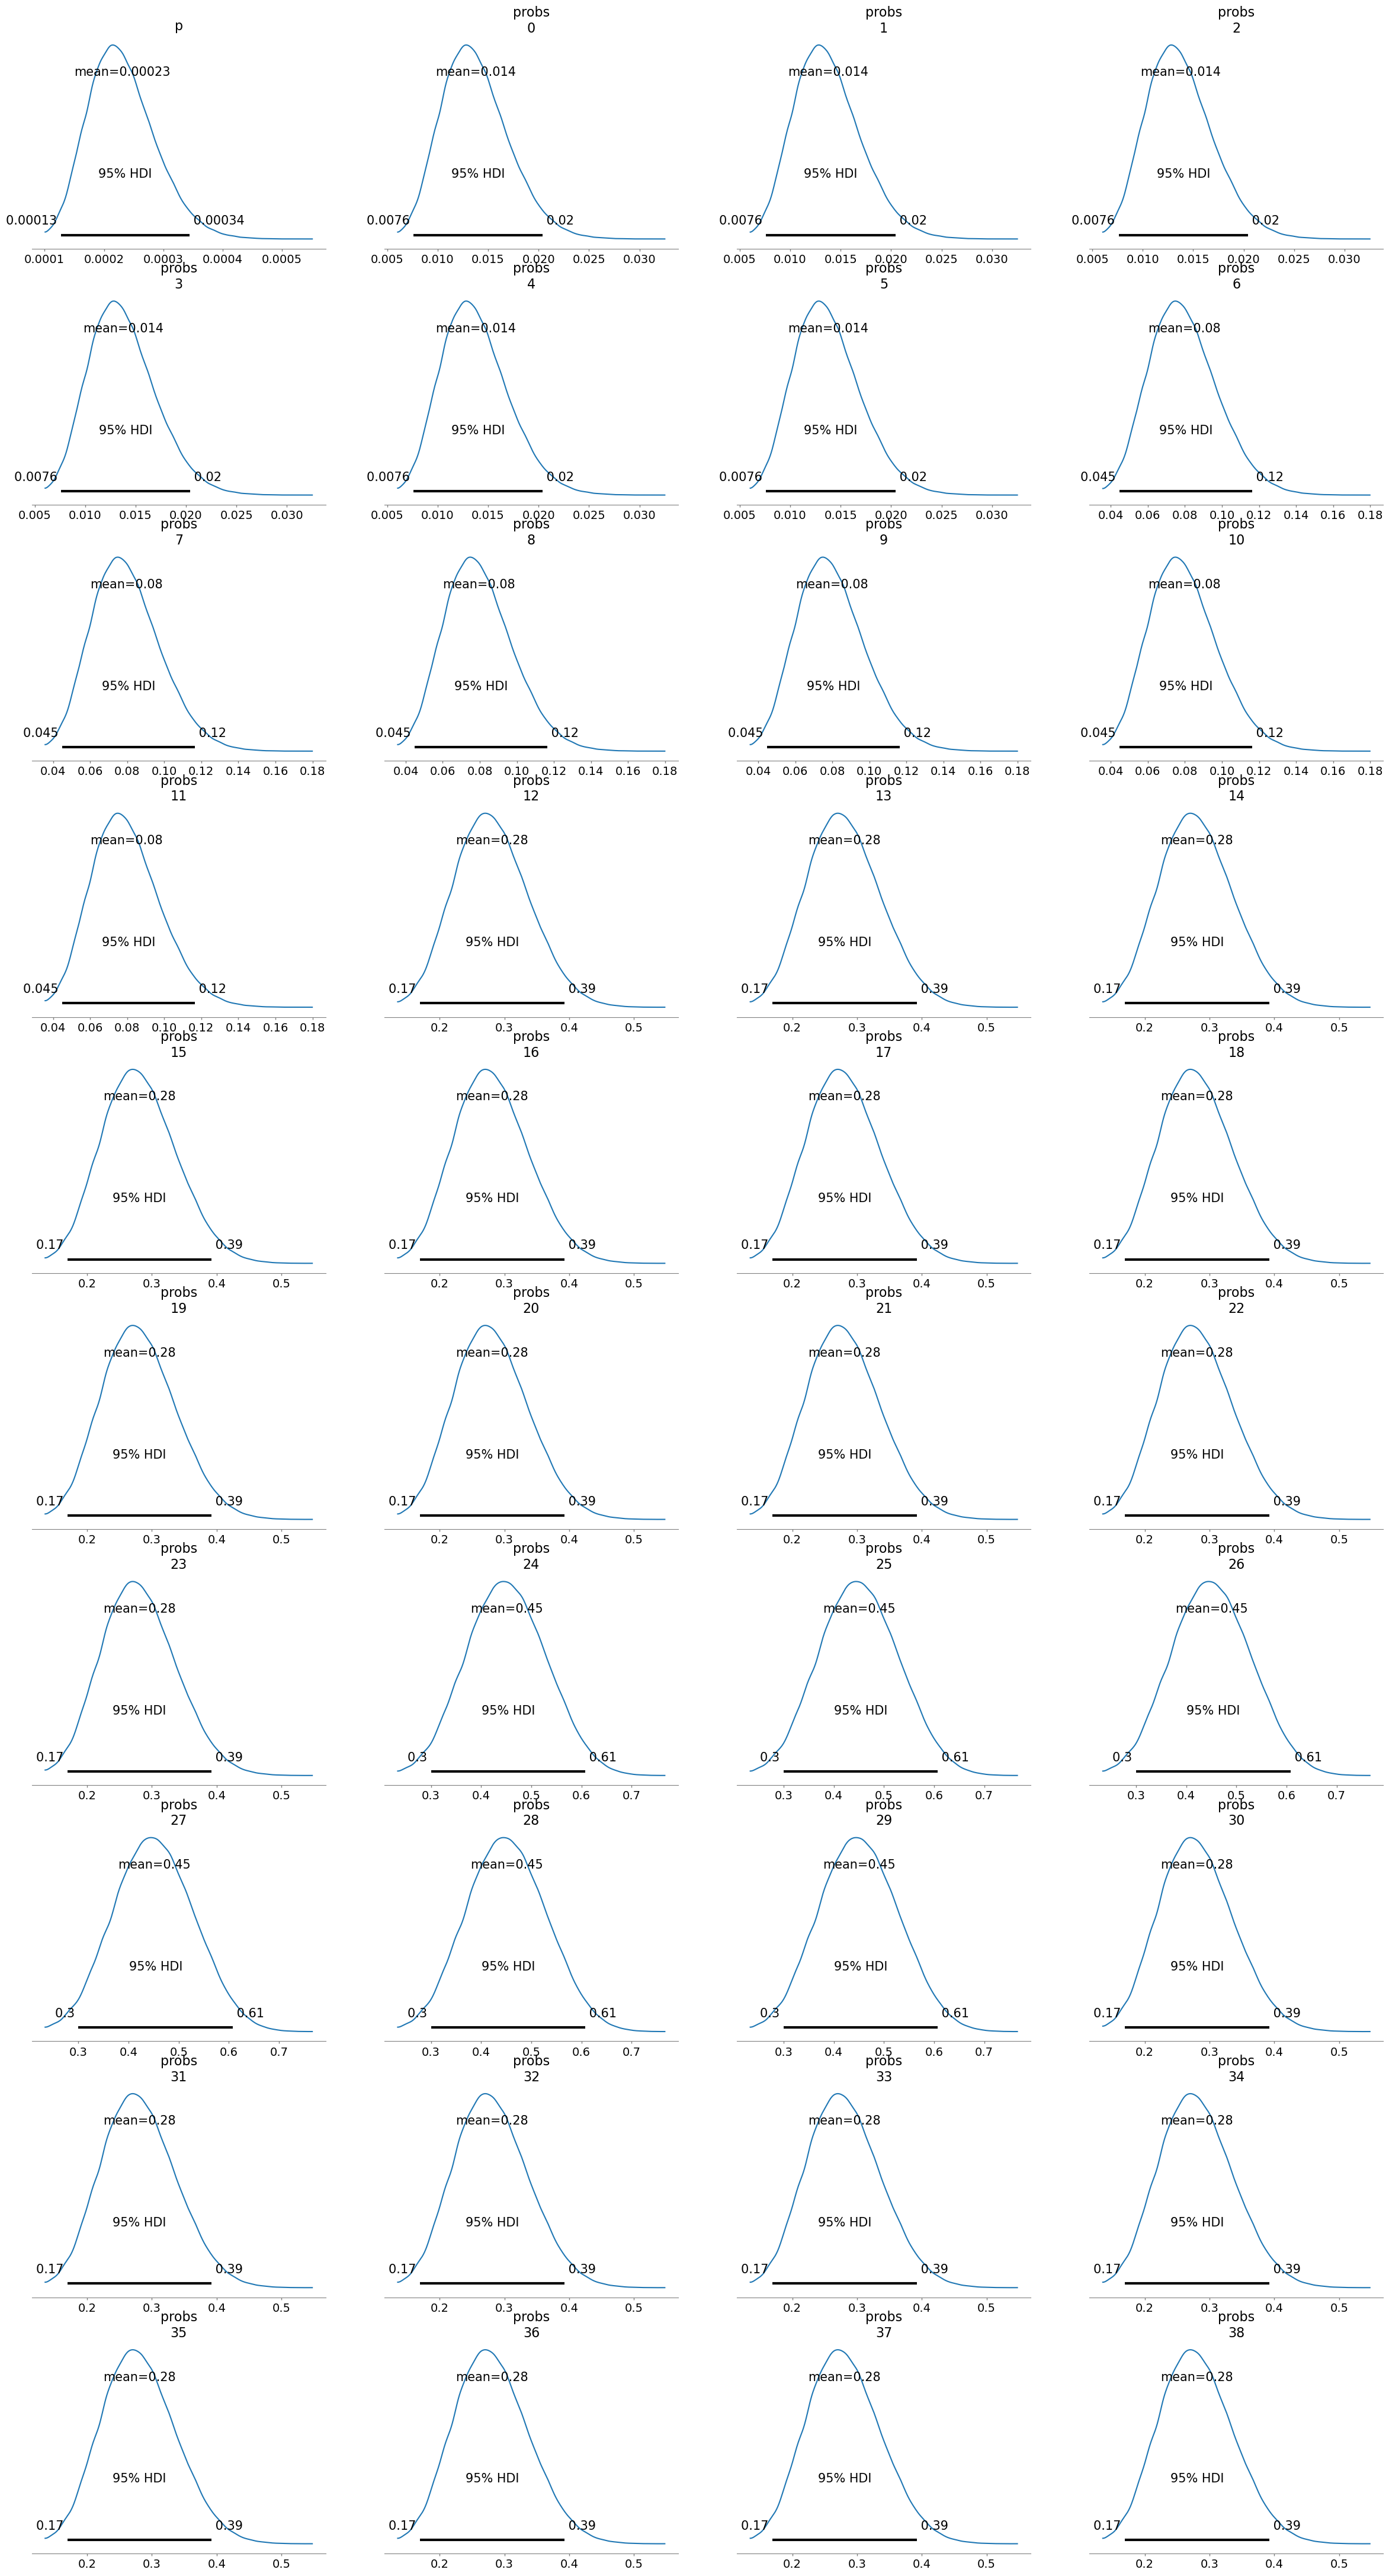

In [9]:
az.plot_posterior(trace_baseline_Bern, hdi_prob=.95);

In [7]:
def process_bernoulli_simulations(trace, df, N):
    """
    Process Bernoulli simulations from a PyMC trace and original dataframe.
    
    Parameters:
    trace (arviz.InferenceData): The trace from a PyMC model.
    df (pd.DataFrame): Original dataframe with 'experiment', 'duration', and 'infected' columns.
    N (list): List of sample sizes for each experiment.
    
    Returns:
    pd.DataFrame: Processed dataframe with cases per experiment.
    """
    try:
        # Extract posterior samples
        samples = trace.posterior.stack(sample=("chain", "draw"))
        
        # Create probability dataframe
        p_list_df = pd.DataFrame(samples['probs'].values)
        p_list_df.columns = p_list_df.add_prefix('pred_').columns
        
        # Perform Bernoulli simulations
        simulations = p_list_df.apply(lambda prob: np.random.binomial(1, prob))
        
        # Combine original data with simulations
        result_df = pd.concat([
            df[["experiment", "duration", "infected"]].reset_index(drop=True),
            simulations.reset_index(drop=True)
        ], axis=1)
        
        # Calculate cases per experiment
        cases_per_exp = result_df.groupby(['experiment', 'duration']).sum().reset_index()
        
        # Add sample sizes and rename columns
        cases_per_exp.insert(2, 'N', N)
        cases_per_exp = cases_per_exp.rename(columns={'infected': 'obs'})
        
        return cases_per_exp
    
    except KeyError as e:
        print(f"Error: Missing expected column in dataframe or trace. {str(e)}")
    except ValueError as e:
        print(f"Error: Mismatch in data shapes or types. {str(e)}")
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")

In [8]:
N = [6, 6, 6 , 6, 6, 5, 6,5, 6, 6, 6]
processed_data = process_bernoulli_simulations(trace_baseline_Bern, df, N)

In [9]:
processed_data

,experiment,duration,N,obs,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,...,pred_99990,pred_99991,pred_99992,pred_99993,pred_99994,pred_99995,pred_99996,pred_99997,pred_99998,pred_99999
0,1,1,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,6,6,0,0,0,1,1,0,0,...,0,0,1,1,1,0,0,1,0,0
2,1,24,6,0,1,2,2,3,2,4,...,1,2,3,1,0,1,2,1,1,3
3,2,24,6,1,1,1,0,1,1,0,...,1,1,2,1,2,0,3,2,2,0
4,2,44,6,4,1,3,2,4,6,4,...,2,0,1,5,3,2,4,4,5,1
5,3,24,5,3,2,1,1,1,1,2,...,3,1,1,2,0,2,3,1,0,0
6,4,24,6,0,0,2,4,3,1,1,...,2,1,3,2,2,0,0,2,3,2
7,4,48,5,4,1,3,1,4,4,4,...,3,2,2,2,2,2,3,4,2,2
8,5,24,6,1,1,1,0,0,1,2,...,2,1,1,1,2,3,3,1,1,0
9,5,48,6,3,1,2,1,2,4,4,...,2,0,4,3,0,2,4,3,3,2


In [10]:
processed_data.to_csv('baseline_bernoulli_pred.csv', index=False)

In [11]:
y = df['infected'].to_numpy()

In [12]:
samples = trace_baseline_Bern.posterior.stack(sample=("chain", "draw"))
p_ind = pd.DataFrame(samples['probs'].values)

In [13]:
def plot_mean_roc2(y_true, posterior_samples, title='Mean ROC curve with 95% CI'):
    fpr_grid = np.linspace(0, 1, 64)
    tpr_interpolated = []
    aucs = []
    
    
    for i in range(posterior_samples.shape[1]):
        y_scores = posterior_samples[i]
        fpr, tpr, _ = roc_curve(y, y_scores)
        tpr_interpolated.append(np.interp(fpr_grid, fpr, tpr))
        aucs.append(auc(fpr, tpr))
    
    # Convertir en array numpy pour faciliter les calculs
    tpr_interpolated = np.array(tpr_interpolated)
    
    # Calculer la TPR moyenne et son intervalle de confiance à 95%
    mean_tpr = tpr_interpolated.mean(axis=0)
    std_tpr = tpr_interpolated.std(axis=0)
    ci_lower = np.percentile(tpr_interpolated, 2.5, axis=0)
    ci_upper = np.percentile(tpr_interpolated, 97.5, axis=0)
    
    # Calculer la moyenne des AUC
    mean_auc = np.mean(aucs)
    lower_auc = np.percentile(aucs, 2.5)
    upper_auc = np.percentile(aucs, 97.5)

    # Create the title with the mean AUC and 95% CI
    title = f'Mean ROC curve with 95% CI (AUC = {mean_auc:.2f}, 95% CI: {lower_auc:.2f} - {upper_auc:.2f})'

    
    # Tracer la courbe ROC moyenne avec les intervalles de confiance
    plt.plot(fpr_grid, mean_tpr, color='blue', label='Mean ROC')
    plt.fill_between(fpr_grid, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

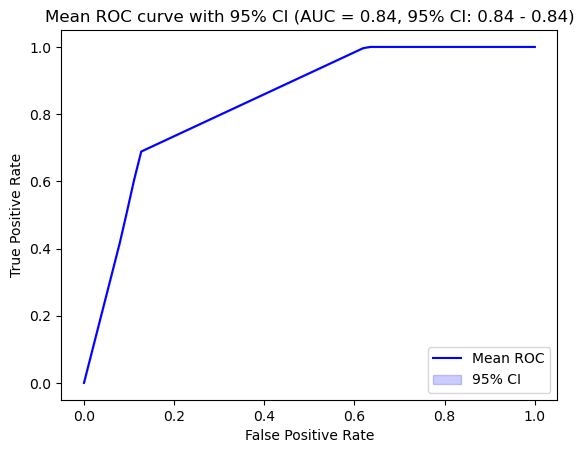

In [14]:
plot_mean_roc2(y, p_ind)